In [227]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import statsmodels as sm
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import *
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
warnings.filterwarnings("ignore")

In [244]:
df = pd.read_csv('./dane/LR_dane_treningowe_testowe.csv')
df.head(1)

,Unnamed: 0,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY,AGE_GROUP
0,0,63581743,0,16MAR39,60.0,0,11.0,67.349,0,0.0,...,1,4.461,2,0,3,0.0,18.0,0,1,5


In [245]:
#https://www.statology.org/likelihood-ratio-test-in-python/
#df.dtypes

def to_categorical(variable):
    lp = 0
    for i in df[variable].unique():
        lp += 1
        df[variable][df[variable] == i] = lp
    return df[variable]#.astype(int)

In [246]:
df = df[df['AGE'] > 15]

In [247]:
df['EDUCATION'] = to_categorical('EDUCATION')
df['EDUCATION'] = df['EDUCATION'].astype(int)
df['OCCUPATION'] = to_categorical('OCCUPATION')
df['OCCUPATION'] = df['OCCUPATION'].astype(int)

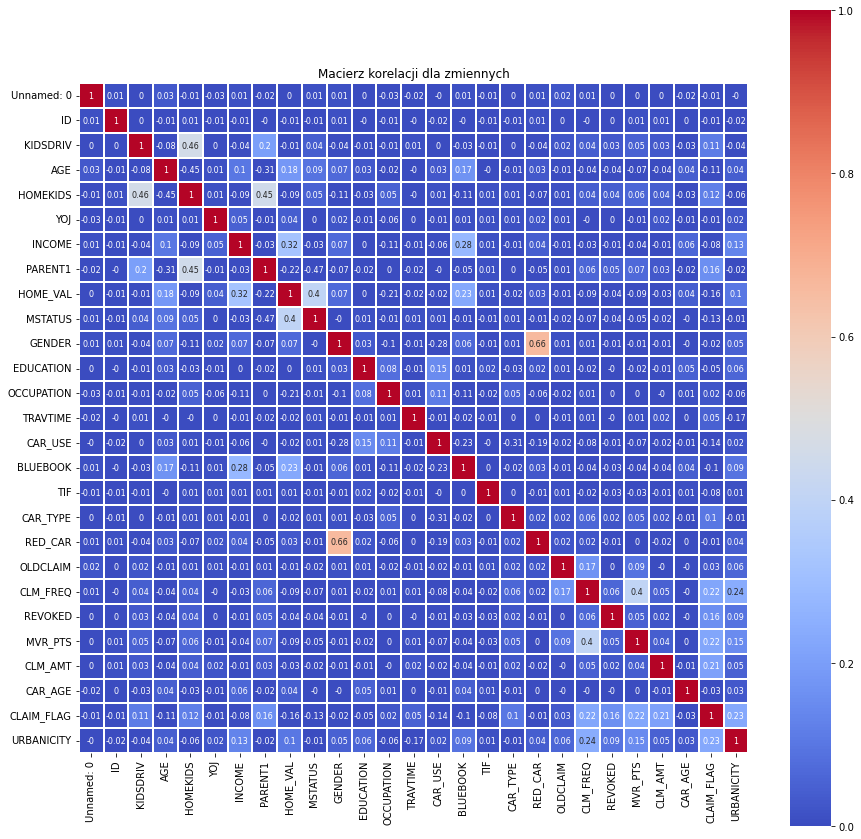

In [248]:
fig=plt.figure(figsize = (15, 15))
ax1 = fig.add_subplot(111)
corr = df.iloc[ : , : -1].corr().round(2)
sns.heatmap(corr, vmin = 0.0, vmax = 1, square=True, linewidths = 0.1, annot = True, annot_kws={"size" : 8}, cmap = "coolwarm")
plt.title("Macierz korelacji dla zmiennych")
plt.show()

In [249]:
df = df.drop(columns = ['RED_CAR', 'AGE_GROUP' ])

In [250]:
w = df['CLAIM_FLAG'].value_counts() / df.shape[0]
w

0    0.733845
1    0.266155
Name: CLAIM_FLAG, dtype: float64

In [251]:
df['sample_weights'] = 0
df['sample_weights'][df['CLAIM_FLAG'] == 0] = w[0]
df['sample_weights'][df['CLAIM_FLAG'] == 1] = w[1]

In [252]:
df

,Unnamed: 0,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,CAR_TYPE,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY,sample_weights
0,0,63581743,0,16MAR39,60.0,0,11.0,67.349,0,0.000,...,1,4.461,2,0,3,0.0,18.0,0,1,0.733845
1,1,132761049,0,21JAN56,43.0,0,11.0,91.449,0,257.252,...,1,0.000,0,0,0,0.0,1.0,0,1,0.733845
2,2,921317019,0,18NOV51,48.0,0,11.0,52.881,0,0.000,...,2,0.000,0,0,2,0.0,10.0,0,1,0.733845
3,3,727598473,0,05MAR64,35.0,1,10.0,16.039,0,124.191,...,3,38.690,2,0,3,0.0,10.0,0,1,0.733845
4,4,450221861,0,05JUN48,51.0,0,14.0,-99.000,0,306.251,...,1,0.000,0,0,0,0.0,6.0,0,1,0.733845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10293,10297,67790126,1,13AUG54,45.0,2,9.0,164.669,0,386.273,...,1,0.000,0,0,2,0.0,17.0,0,1,0.733845
10294,10298,61970712,0,17JUN53,46.0,0,9.0,107.204,0,332.591,...,5,0.000,0,0,0,0.0,1.0,0,1,0.733845
10295,10299,849208064,0,18JUN51,48.0,0,15.0,39.837,0,170.611,...,3,0.000,0,0,0,0.0,1.0,0,1,0.733845
10296,10300,627828331,0,12DEC48,50.0,0,7.0,43.445,0,149.248,...,1,0.000,0,0,0,0.0,11.0,0,1,0.733845


In [253]:
'''
x_cols = ['INCOME', 'HOME_VAL','CAR_AGE']
for col in x_cols:
    std = df[col].std()
    mean = df[col].mean()
    outliers = (df[col] > ((3 * std) + mean)) | ((mean - (3 * std)) > df[col])
    print( f"W zmiennej {col} zidentyfikowano {outliers.sum()} rekordów ({round(outliers.sum() / df[col].notna().sum(),2)}%) jako wartości odstające")
    df['outlier'] = outliers
    df = df[df['outlier'] == False]
'''

'\nx_cols = [\'INCOME\', \'HOME_VAL\',\'CAR_AGE\']\nfor col in x_cols:\n    std = df[col].std()\n    mean = df[col].mean()\n    outliers = (df[col] > ((3 * std) + mean)) | ((mean - (3 * std)) > df[col])\n    print( f"W zmiennej {col} zidentyfikowano {outliers.sum()} rekordów ({round(outliers.sum() / df[col].notna().sum(),2)}%) jako wartości odstające")\n    df[\'outlier\'] = outliers\n    df = df[df[\'outlier\'] == False]\n'

In [254]:
df['Nrow'] = [x for x in range(df.shape[0])] 

In [255]:
ids = random.sample(list(df['Nrow'].values), int(.70*df.shape[0]))
df_train = df[df['Nrow'].isin(ids)]
df_test = df[~df['Nrow'].isin(ids)]

Text(0, 0.5, 'Liczebność')

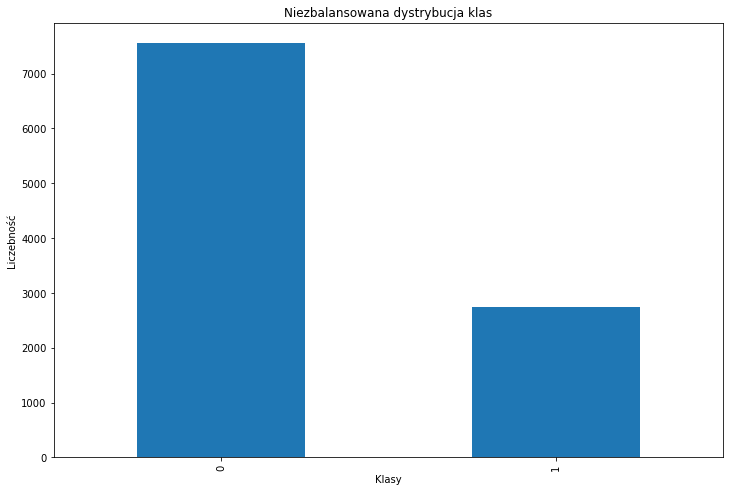

In [256]:
plt.figure(figsize=(12, 8))
df.CLAIM_FLAG.value_counts().nlargest(10).sort_values(ascending=False).plot.bar()
plt.title("Niezbalansowana dystrybucja klas")
plt.xlabel("Klasy")
plt.ylabel("Liczebność")

In [257]:
df_train.iloc[:,6:].head(2)

,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,...,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY,sample_weights,Nrow
1,11.0,91.449,0,257.252,0,1,2,2,22,0,...,0.0,0,0,0,0.0,1.0,0,1,0.733845,1
2,11.0,52.881,0,0.000,0,1,3,3,26,1,...,0.0,0,0,2,0.0,10.0,0,1,0.733845,2


In [258]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.preprocessing import StandardScaler

In [259]:
X = df[['KIDSDRIV','AGE','HOMEKIDS','INCOME','PARENT1','HOME_VAL','MSTATUS','GENDER','EDUCATION','OCCUPATION','TRAVTIME',
        'CAR_USE','BLUEBOOK','TIF','CAR_TYPE','OLDCLAIM','CLM_FREQ','REVOKED','MVR_PTS','CAR_AGE','URBANICITY']]

y = pd.get_dummies(df[['CLAIM_FLAG']])
y

,CLAIM_FLAG
0,0
1,0
2,0
3,0
4,0
...,...
10293,0
10294,0
10295,0
10296,0


In [260]:
nominalne = ['AGE', 'INCOME','HOME_VAL', 'TRAVTIME','CAR_AGE' ]
kateg = ['KIDSDRIV','HOMEKIDS','PARENT1','MSTATUS','GENDER','EDUCATION',
         'OCCUPATION','CAR_USE','BLUEBOOK','TIF','CAR_TYPE','OLDCLAIM','CLM_FREQ','REVOKED','MVR_PTS','URBANICITY']

scaler = StandardScaler()
scaler.fit(X[nominalne])

X[nominalne] = scaler.transform(X[nominalne])


In [261]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [262]:
#sns.set(style="dark")
#sns.pairplot(data = X.sample(5000)) 
#plt.show()

In [263]:
clf = LogisticRegression(random_state=0)

sfs1 = SFS(clf , k_features=14, 
                   forward=True,
                   floating=False, 
                   verbose=2,
                   scoring='r2',
                   cv=5)

features = sfs1.fit(np.array(X_train), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    1.1s finished

[2022-06-17 13:08:54] Features: 1/14 -- score: -0.315433440570385[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.6s finished

[2022-06-17 13:08:56] Features: 2/14 -- score: -0.3095391399985049[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.6s finished

[2022-06-17 13:08:57] Features: 3/14 -- score: -0.2948171554876234[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done

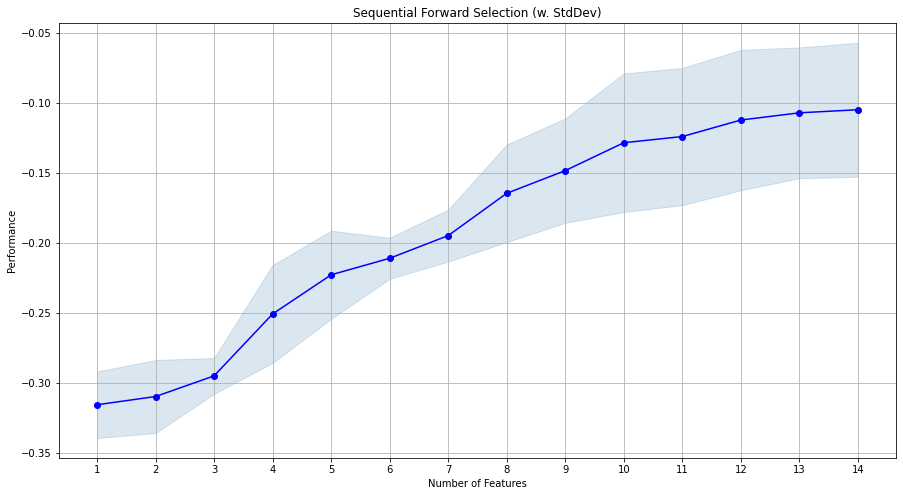

In [264]:
fig1 = plot_sfs(features.get_metric_dict(), kind='std_dev',figsize=(15,8))
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [265]:
filtered_features = X.columns[list(features.k_feature_idx_)]
filtered_features

Index(['KIDSDRIV', 'HOMEKIDS', 'INCOME', 'PARENT1', 'EDUCATION', 'OCCUPATION',
       'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'REVOKED',
       'MVR_PTS', 'URBANICITY'],
      dtype='object')

In [266]:
string = ''
for cols in filtered_features:
    string = ' + '.join([string, cols])

formula = 'CLAIM_FLAG~' + string[2:]
formula

'CLAIM_FLAG~ KIDSDRIV + HOMEKIDS + INCOME + PARENT1 + EDUCATION + OCCUPATION + TRAVTIME + CAR_USE + BLUEBOOK + TIF + CAR_TYPE + REVOKED + MVR_PTS + URBANICITY'

In [267]:
#formula = 'CLAIM_FLAG~ KIDSDRIV + AGE +  INCOME + PARENT1 + MSTATUS + GENDER + TRAVTIME + CAR_USE + BLUEBOOK + TIF + CAR_TYPE + REVOKED + MVR_PTS + CAR_AGE + URBANICITY'

MLE -  Maximum Likelihood Estimation

In [268]:
m1 = smf.logit(formula = formula, data = df_train).fit() #, sample_weight = df_train['sample_weights']

Optimization terminated successfully.
         Current function value: 0.470958
         Iterations 7


In [269]:
print(m1.summary().tables[0])

                           Logit Regression Results                           
Dep. Variable:             CLAIM_FLAG   No. Observations:                 7203
Model:                          Logit   Df Residuals:                     7188
Method:                           MLE   Df Model:                           14
Date:                Fri, 17 Jun 2022   Pseudo R-squ.:                  0.1843
Time:                        13:09:44   Log-Likelihood:                -3392.3
converged:                       True   LL-Null:                       -4159.0
Covariance Type:            nonrobust   LLR p-value:                     0.000


In [270]:
full_ll = m1.llf

In [271]:
print(m1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9198      0.196    -14.871      0.000      -3.305      -2.535
KIDSDRIV       0.3660      0.064      5.751      0.000       0.241       0.491
HOMEKIDS       0.0504      0.033      1.508      0.131      -0.015       0.116
INCOME        -0.0030      0.001     -5.941      0.000      -0.004      -0.002
PARENT1        0.8589      0.093      9.201      0.000       0.676       1.042
EDUCATION     -0.0770      0.024     -3.185      0.001      -0.124      -0.030
OCCUPATION     0.0350      0.012      2.950      0.003       0.012       0.058
TRAVTIME       0.0171      0.002      8.788      0.000       0.013       0.021
CAR_USE       -0.8139      0.068    -11.921      0.000      -0.948      -0.680
BLUEBOOK      -0.0380      0.004     -9.592      0.000      -0.046      -0.030
TIF           -0.0581      0.008     -7.567      0.0

In [280]:
p = 0.55
y_pred = m1.predict(df_test)
y_pred_kwant = y_pred.copy()
y_pred_kwant[y_pred_kwant >= p] = 1
y_pred_kwant[y_pred_kwant < p] = 0

In [281]:
print(confusion_matrix(df_test["CLAIM_FLAG"], y_pred_kwant.astype(np.int32)))

[[2154   98]
 [ 602  234]]


In [282]:
y_pred_kwant.unique()

array([0., 1.])

In [283]:
acc = round(accuracy_score(y_pred_kwant, df_test["CLAIM_FLAG"]),2)*100
b_acc = round(balanced_accuracy_score(y_pred_kwant,df_test["CLAIM_FLAG"]),2)*100

print(f'Dokładność wynosi {acc} %, ale bieda')
print(f'Zbalansowana dokładność wynosi {b_acc} %, żenada')

Dokładność wynosi 77.0 %, ale bieda
Zbalansowana dokładność wynosi 74.0 %, żenada


In [284]:
print(f'Area Under Curve: {roc_auc_score(y_pred_kwant, df_test["CLAIM_FLAG"])}')
print(f'Recall score: {recall_score(y_pred_kwant, df_test["CLAIM_FLAG"])}')

Area Under Curve: 0.7431933831115463
Recall score: 0.7048192771084337


In [285]:
fpr, tpr, _ = roc_curve(df_test["CLAIM_FLAG"], y_pred)
roc_auc = auc(fpr, tpr)

No handles with labels found to put in legend.


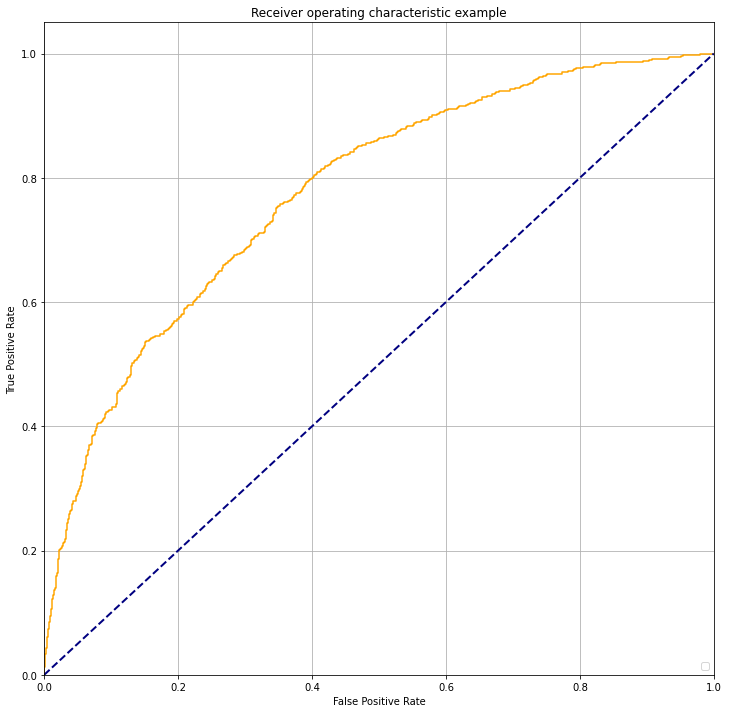

In [286]:
plt.figure(figsize=(12,12))
lw = 2
plt.plot(fpr, tpr,color="orange")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.grid()

plt.show()